In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [2]:
# Подсчитывает расстояние Хэмминга
def vector_dist(vect1, vect2):
    return np.sum(np.abs(vect1 - vect2))

# Перемножает матрицы в F2
def multiply_matrix(mat1, mat2):
    return np.mod(np.dot(mat1, mat2), 2)

# Получает все возможные двоичные вектора заданной длины
def generate_binary_vectors(vect_len):
    def get_all_vectors(vector_len, cur_vectors):
        if len(cur_vectors[0]) == vector_len: # если вектора уже нужного размера, возвращаем их
            return cur_vectors
        
        # в противном случае каждый вектор может быть продолжен двумя способами:
        # нулём и единицей
        new_vectors = []
        for cur_vector in cur_vectors:
            cur_vector_zero = cur_vector[:]
            cur_vector_zero.append(0)

            cur_vector_one = cur_vector[:]
            cur_vector_one.append(1)
            new_vectors.append(cur_vector_zero)
            new_vectors.append(cur_vector_one)
        return get_all_vectors(vector_len, new_vectors)
    
    answer = get_all_vectors(vect_len, [[]])
    assert len(answer) == 2 ** vect_len
    
    # оборачиваем в numpy-массивы для ускорения вычислений
    return np.array(answer)

In [3]:
# Порождающая матрица кода Голея
G = np.array(
    [
        [1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,0,0,1],
        [0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,1,0,0,1],
        [0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0,1],
        [0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,1,0,1,1],
        [0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,0,1,1,0,0],
        [0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,0,1,1,0],
        [0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,0,1,1],
        [0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1,1,1,1,0,0],
        [0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1,1,1,1,0],
        [0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1,1,1,1],
        [0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,0,0,1,1,0],
        [0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,0,0,1,1]
    ]
)

# 12 - размер сообщения до кодирования
# 23 - размер сообщения после кодирования
k = 12
n = 23

Eb = 1 # Фиксируем произвольным образом энергию на передаваемый бит

# Передаваемые сообщения - все вектора размера k
messages = generate_binary_vectors(k)

assert messages.shape == (2 ** k, k)

In [4]:
codewords = np.array([
    multiply_matrix(cur_message, G) for cur_message in messages
])

assert codewords.shape == (2 ** k, n)

In [5]:
# При жёстком декодировании полученный вектор должен быть битовым
# а при мягком - состоять из модуляций    
def decode_hard(received_word, codewords):
    distances = np.array([vector_dist(received_word, cur_codeword) for cur_codeword in codewords])
    return messages[np.argmin(distances)]

def decode_soft(received_word, codewords):
    modulated_codewords = np.array([(2 * codeword - 1) for codeword in codewords])
    scalar_products = np.array([
        np.dot(cur_modulated_codeword, received_word) for cur_modulated_codeword in modulated_codewords
    ])
    return messages[np.argmax(scalar_products)]
    
# преобразует полученные модуляции в биты для жёсткого декодирования
# в случае мягкого декодирования никак преобразовывать модуляции не надо
demodulate_hard = np.vectorize(lambda x: 1 if x >= 0 else 0)    
    
# 10 * lg(Eb / N0) = t => lg(Eb / N0) = t / 10 => Eb / N0 = 10 ** (t / 10) => N0 = Eb / (10 ** (t / 10))
# Таким образом можно вычислить N0
# моделирует отправку по каналу с аддитивным белым гауссовским шумом
def send(codeword_to_send, snr):
    N0 = Eb / (10 ** (snr / 10)) # по отношению сингал/шум получаем N0
    Ec = Eb * k / len(codeword_to_send) # энергия на передаваемый символ
    noise = np.random.normal(0, math.sqrt(N0 / 2), len(codeword_to_send)) # добавляем аддитивный гауссовский белый шум
    return (2 * codeword_to_send - 1) * math.sqrt(Ec) + noise

In [6]:
# Моделирует отправку сообщения с кодированием, возвращая расстояние между отправленным и полученным вектором
def send_with_encoding(msg, snr, decoder_type):
    code_word = multiply_matrix(msg, G) # По k-битному слову получаем n-битный код
    # внося избыточность в данные
    moduled_received = send(code_word, snr) # Превращение бит в модуляции и добавление АБГШ
    if decoder_type == 'hard':
        received_word = demodulate_hard(moduled_received)
        received_msg = decode_hard(received_word, codewords)
    else:
        received_msg = decode_soft(moduled_received, codewords)
    return vector_dist(msg, received_msg)

# Моделирует отправку сообщения без кодирования, возвращая расстояние между отправленным и полученным вектором
def send_without_encoding(msg, snr, decoder_type):
    signals = send(msg, snr)
    if decoder_type == 'hard':
        return vector_dist(msg, demodulate_hard(signals))
    else:
        received_msg = decode_soft(signals, messages)
        return vector_dist(msg, received_msg)

In [7]:
# message_sender - функция, используемая для моделирования отправки сообщения. Может
# быть функцией с кодированием, а может без
# возвращает вероятность ошибки в одном бите (переходную вероятность)
def get_p(snr, message_sender, decoder_type):
    sum_res = 0
    retries = 30
    for i in range(retries):
        for msg in messages:
            sum_res += message_sender(msg, snr, decoder_type)
    return sum_res / (retries * (2 ** k) * k)

In [8]:
snrs = list(np.arange(-2, 12, 0.25)) # различные отношения сигнал/шум

In [9]:
soft_encode = np.array([get_p(cur_snr, send_with_encoding, 'soft') for cur_snr in tqdm_notebook(snrs)])

In [10]:
soft_no_encode = np.array([get_p(cur_snr, send_without_encoding, 'soft') for cur_snr in tqdm_notebook(snrs)])

In [11]:
soft_encode

array([1.93342421e-01, 1.80802409e-01, 1.67751736e-01, 1.55457899e-01,
       1.39987522e-01, 1.26988390e-01, 1.13816325e-01, 1.01135254e-01,
       8.84155273e-02, 7.67523872e-02, 6.53198242e-02, 5.44582791e-02,
       4.51504178e-02, 3.60283746e-02, 2.87753635e-02, 2.32116699e-02,
       1.76649306e-02, 1.26288520e-02, 9.53097873e-03, 6.53415256e-03,
       4.81431749e-03, 2.89306641e-03, 1.98771159e-03, 1.29869249e-03,
       7.85319010e-04, 4.79465061e-04, 2.51600477e-04, 1.68185764e-04,
       5.28971354e-05, 3.05175781e-05, 3.93337674e-05, 4.74717882e-06,
       5.42534722e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [12]:
soft_no_encode

array([1.30994331e-01, 1.23699273e-01, 1.17082384e-01, 1.10195584e-01,
       1.03555637e-01, 9.76867676e-02, 9.10624186e-02, 8.43587240e-02,
       7.84918891e-02, 7.23381890e-02, 6.69867622e-02, 6.17926704e-02,
       5.63422309e-02, 5.13827854e-02, 4.66356066e-02, 4.18409559e-02,
       3.77529568e-02, 3.35734049e-02, 2.93341743e-02, 2.61583116e-02,
       2.29092068e-02, 1.97903103e-02, 1.72024197e-02, 1.47738987e-02,
       1.23813205e-02, 1.04939779e-02, 8.67513021e-03, 7.31065538e-03,
       5.97534180e-03, 4.87738715e-03, 3.87573242e-03, 3.06057400e-03,
       2.43733724e-03, 1.88530816e-03, 1.41669379e-03, 1.06947157e-03,
       7.75824653e-04, 5.79833984e-04, 4.00797526e-04, 2.81439887e-04,
       2.10910373e-04, 1.32921007e-04, 8.40928819e-05, 6.30696615e-05,
       3.18739149e-05, 2.64485677e-05, 8.13802083e-06, 6.78168403e-06,
       3.39084201e-06, 1.35633681e-06, 1.35633681e-06, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

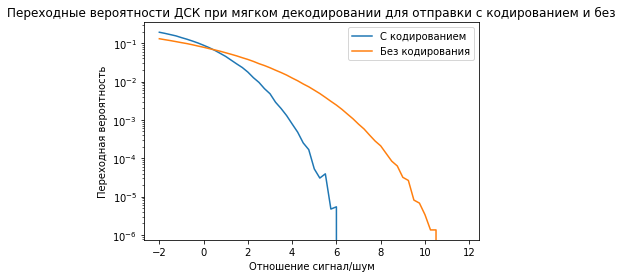

In [13]:
plt.figure()
plt.semilogy(snrs, soft_encode, label='С кодированием')
plt.semilogy(snrs, soft_no_encode, label='Без кодирования')
plt.legend(loc='upper right')
plt.title('Переходные вероятности ДСК при мягком декодировании для отправки с кодированием и без')
plt.xlabel('Отношение сигнал/шум')
plt.ylabel('Переходная вероятность')
plt.show()

In [14]:
soft_encode.shape, soft_no_encode.shape, len(snrs)

((56,), (56,), 56)

In [15]:
dists = [] 
# разность между отношением сигнал/шум, необходимым для достижения заданной вероятности ошибок
# с кодированием и без
dist_ps = [] # заданные вероятности ошибок

for ind in range(len(snrs)):
    if soft_encode[ind] > 1e-9: # выбираем ненулевую вероятность ошибок при отправке с кодированием
        nearest_p_ind = np.argmin(abs(soft_no_encode - soft_encode[ind])) 
        # находим индекс ближайшей к ней вероятности ошибки при отправке без кодирования
        dists.append(snrs[nearest_p_ind] - snrs[ind]) # сохраняем разность между отношениями сигнал/шум
        dist_ps.append(soft_encode[ind]) # и заданную вероятность

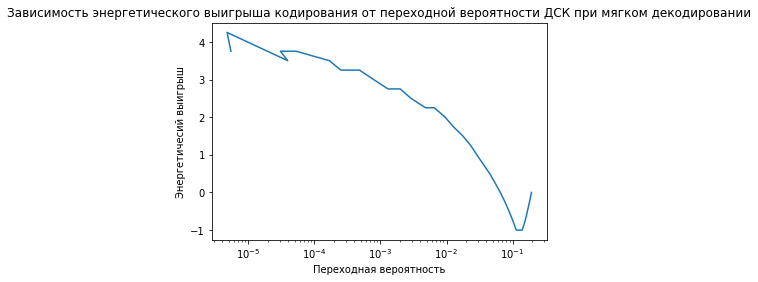

In [16]:
plt.semilogx(dist_ps, dists)
plt.title('Зависимость энергетического выигрыша кодирования от переходной вероятности ДСК при мягком декодировании')
plt.xlabel('Переходная вероятность')
plt.ylabel('Энергетичесий выигрыш')
plt.show()